In [949]:
# pip install xgboost
# pip install hyperopt
#https://hyperopt.github.io/hyperopt/?source=post_page
# pip install category_encoders
# pip install scikit-optimize
# pip install dtreeviz


**Install Libraries**

In [950]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

import shap
from IPython.display import display

from xgboost import plot_importance
from xgboost import XGBRegressor, plot_importance, plot_tree, plotting

import dtreeviz
import graphviz


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold 
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder

# #for hyperparameter tuning
# import hyperopt
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


**Load datasets**

In [951]:
def load_dataset(data):
    df = pd.read_csv(data)
   
    return df


In [952]:
df_bb= load_dataset('cleaned_files/basketball_clean_supervised.csv')
df_fb= load_dataset('cleaned_files/football_clean_supervised.csv')

In [953]:
df_fb.head(3)

,Unnamed: 0,NAME,GRADE,AGE,SKILL,STARCOLL,NUMOFF,POS,HEIGHT_IN,WEIGHT_LBS,...,TIK_LONG,TOT_FOL,SPORT,RECRUIT_YEAR,EXP_MONTHS,EXP_YEARS,institution_name_short,ClassificationCode,REV_MEN,EXP_MEN
0,0,Arch Manning,2.0,18.28281,99.53,Texas,18.0,1.0,75.5,220.0,...,8900.0,73900.0,football,2023.0,2.0,0.189041,Texas,1.0,161532860.0,50633156.0
1,1,Anthony Hill,2.0,18.00000,97.87,Texas,25.0,8.0,73.5,225.0,...,0.0,13100.0,football,2023.0,2.0,0.189041,Texas,1.0,161532860.0,50633156.0
2,2,CJ Baxter Jr.,2.0,18.00000,97.26,Texas,25.0,9.0,73.0,216.0,...,1700.0,10900.0,football,2023.0,2.0,0.189041,Texas,1.0,161532860.0,50633156.0


In [954]:
#save athlete names for later indexing
athletes_fb = df_fb['NAME']
athletes_bb = df_bb['NAME']
# athlete_names

df_bb = df_bb.drop(columns=['Unnamed: 0', 'NAME','SPORT','STARCOLL','EXP_YEARS','institution_name_short'])
df_fb= df_fb.drop(columns=['Unnamed: 0', 'NAME','SPORT', 'STARCOLL','EXP_YEARS','institution_name_short'])


In [955]:

df_fb.columns
# df_fb.info()

Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'NILVAL_LONG_USD', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'TOT_FOL', 'RECRUIT_YEAR', 'EXP_MONTHS', 'ClassificationCode',
       'REV_MEN', 'EXP_MEN'],
      dtype='object')

In [956]:
df_bb.columns

Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'NILVAL_LONG_USD', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'TOT_FOL', 'RECRUIT_YEAR', 'EXP_MONTHS', 'ClassificationCode',
       'REV_MEN', 'EXP_MEN'],
      dtype='object')

**Standard Train Test Split**

In [957]:

def split_data(df, train_size_=0.70, valid_size_=0.15, test_size_=0.15, random_state=42):
    # Log-transform y
    df=df.copy()
    y = df.pop("NILVAL_LONG_USD")
    # y = np.log1p(y)
    X = df
    # scaler = StandardScaler()
    # X_scaled = scaler.fit_transform(X) 

    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=valid_size_ + test_size_, 
    shuffle = True, random_state=random_state)
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=test_size_ / (valid_size_ + test_size_), shuffle = True, random_state=random_state)

    # X_train = pd.DataFrame(X_train, columns=X.columns)
    # X_valid = pd.DataFrame(X_valid, columns=X.columns)
    # X_test = pd.DataFrame(X_test, columns=X.columns)

    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [958]:
X_train_bb, y_train_bb, X_valid_bb, y_valid_bb, X_test_bb, y_test_bb = split_data(df_bb)
X_train_fb, y_train_fb, X_valid_fb, y_valid_fb, X_test_fb, y_test_fb = split_data(df_fb)

print((X_train_bb.shape,y_train_bb.shape ),(X_valid_bb.shape, y_valid_bb.shape),(X_test_bb.shape, y_test_bb.shape))
print((X_train_fb.shape,y_train_fb.shape ),(X_valid_fb.shape, y_valid_fb.shape),(X_test_fb.shape, y_test_fb.shape))

((95, 17), (95,)) ((21, 17), (21,)) ((21, 17), (21,))
((884, 17), (884,)) ((189, 17), (189,)) ((190, 17), (190,))


In [959]:
# df_bb= df_bb.copy()
# y_bb = df_bb.pop("NILVAL_LONG_USD")
# X_bb= df_bb


# df_fb= df_fb.copy()
# y_fb = df_fb.pop("NILVAL_LONG_USD")
# X_fb= df_fb

**Establish baseline metrics**

In [960]:
def baseline(name, X_train, X_valid, X_test, y_train, y_valid, y_test):
    
    # random_state = 42

  # # Split the data into training, validation, and test sets
  #   test_size=0.15
  #   validation_size= 0.15
  #   X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=random_state)
  #   X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=validation_size, random_state=random_state)

    mean_target = np.mean(y_train)

    # Create an array with the same shape as y_val filled with the mean value
    baseline_predictions = np.full_like(y_valid, mean_target)

    # Calculate the Mean Squared Error (MSE) for the baseline
    baseline_mse = mean_squared_error(y_valid, baseline_predictions)
    baseline_mse  = round(baseline_mse, 3)

    # Calculate the RMSE (square root of MSE)
    # baseline_rmse = np.math.sqrt(baseline_mse)
    baseline_rmse = np.sqrt(mean_squared_error(y_valid, baseline_predictions))
    baseline_rmse = round(baseline_rmse,3)

    # Calculate the Mean Absolute Error (MAE) for the baseline
    baseline_mae = mean_absolute_error(y_valid, baseline_predictions)

    baseline_mae = round(baseline_mae, 3)

    # Calculate the R2 for the baseline
    baseline_r2 = r2_score(y_valid, baseline_predictions)
    baseline_r2 = round(baseline_r2, 3)

    baseline = {
    "Model": "Baseline",
    "Dataset": "{}".format(name),
    "Baseline MSE": baseline_mse,
      "Baseline MAE": baseline_mae ,
    "Baseline RMSE": baseline_rmse,
    'Baseline R2' : baseline_r2,
    

}, 
    return  pd.DataFrame(baseline)

    

In [961]:
baseline_bb = baseline('Basketball', X_train_bb, X_valid_bb, X_test_bb, y_train_bb, y_valid_bb, y_test_bb)
baseline_fb = baseline ('Football', X_train_fb, X_valid_fb, X_test_fb, y_train_fb, y_valid_fb, y_test_fb)
baselines = pd.concat([baseline_bb, baseline_fb ], axis=0)
display(baselines)

,Model,Dataset,Baseline MSE,Baseline MAE,Baseline RMSE,Baseline R2
0,Baseline,Basketball,4.794842e+10,183633.083,218971.276,-0.063
0,Baseline,Football,1.911756e+10,84890.056,138266.252,-0.027


**Establish simple baseline regressor- Using Linear Regression**

In [962]:


def establish_baseline_metrics(name, X, y, valid_size_=0.15, test_size_=0.15):
    random_state = 42

    # Split the data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=valid_size_ + test_size_, 
                                                       shuffle=True, random_state=random_state)
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=test_size_ / (valid_size_ + test_size_), 
                                                       shuffle=True, random_state=random_state)

    # Create and fit a baseline linear regression model
    baseline_model = LinearRegression()
    baseline_model.fit(X_train, y_train)

    # Make predictions on the validation set
    baseline_predictions = baseline_model.predict(X_valid)

    # Calculate the Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_valid, baseline_predictions))

    # Calculate the R-squared (R^2) score
    r2 = r2_score(y_valid, baseline_predictions)

    # Calculate the Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_valid, baseline_predictions)

    # Create a DataFrame to store the results
    baseline_results = pd.DataFrame({
        "Model": ["Linear Regression"],
        "Dataset": [name],
        "Baseline MAE": [round(mae, 3)],
        "Baseline RMSE": [round(rmse, 3)],
        "Baseline R2": [round(r2, 3)]
    })

    print("Train shapes:", X_train.shape, y_train.shape)
    print("Validation shapes:", X_valid.shape, y_valid.shape)
    print("Test shapes:", X_test.shape, y_test.shape)

    return baseline_results


In [963]:
lrbase_bb = establish_baseline_metrics('Basketball',X_bb,y_bb)
lr_base_fb = establish_baseline_metrics('Football', X_fb,y_fb)
baselines_lr = pd.concat([lrbase_bb, lr_base_fb ], axis=0)
display(baselines_lr)


Train shapes: (95, 17) (95,)
Validation shapes: (21, 17) (21,)
Test shapes: (21, 17) (21,)
Train shapes: (884, 17) (884,)
Validation shapes: (189, 17) (189,)
Test shapes: (190, 17) (190,)


,Model,Dataset,Baseline MAE,Baseline RMSE,Baseline R2
0,Linear Regression,Basketball,167695.635,213437.827,-0.010
0,Linear Regression,Football,81855.009,125865.883,0.149


**Build and Train XGBoost Regressor**

In [964]:

def xgb_regressor(name, X_train, X_valid, y_train, y_valid, params=None):
    # Initialize XGBoost Regressor with optional hyperparameters
    if params is None:
        params = {}
    xgb_regressor = xgb.XGBRegressor(eval_metric='mae', **params)
    
    # Fit the model on the training set
    xgb_regressor.fit(X_train, y_train)
    
    # Predict on the validation set
    y_valid_pred = xgb_regressor.predict(X_valid)

    mse_valid = mean_squared_error(y_valid, y_valid_pred)
    mae_valid = mean_absolute_error(y_valid, y_valid_pred)
    rmse_valid = mean_squared_error(y_valid, y_valid_pred, squared=False)
    r2_valid = r2_score(y_valid, y_valid_pred)
    
    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        "Model": ["XGB Regressor (Validation Set)"],
        "Dataset": [name],
        "MAE": [round(mae_valid, 3)],
        "RMSE": [round(rmse_valid, 3)],
        "R2": [r2_valid],
    })

    return xgb_regressor, results_df



In [965]:
xgb_bb, results_bb = xgb_regressor('Basketball', X_train_bb, X_valid_bb, y_train_bb, y_valid_bb, params=None)
xgb_fb, results_fb = xgb_regressor('Football', X_train_fb, X_valid_fb, y_train_fb, y_valid_fb, params=None)
xgb_df = pd.concat([results_bb, results_fb ], axis=0)
display(xgb_df)

,Model,Dataset,MAE,RMSE,R2
0,XGB Regressor (Validation Set),Basketball,101067.325,254039.210,-0.430829
0,XGB Regressor (Validation Set),Football,55250.265,112424.741,0.320810


In [966]:
# import xgboost as xgb
# import numpy as np
# import pandas as pd
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# def baseline_xgb(name, X_train, X_valid, X_test, y_train, y_valid, y_test):

#     # Create an XGBoost regressor with multiple evaluation metrics
#     baseline_xgb = xgb.XGBRegressor(
#         objective='reg:squarederror',
#         n_estimators=1000,
#         learning_rate=0.1,
#         max_depth=3,
#         subsample=1.0,
#         colsample_bytree=1.0,
#         random_state=42,
#         tree_method='auto',
#         eval_metric=['mae', 'rmse'],  # Add multiple metrics as a list
#         early_stopping_rounds=10 
#     )

#     # Fit the model to the training data with early stopping
#     baseline_xgb.fit(
#         X_train,
#         y_train,
#         eval_set=[(X_valid, y_valid)],
#         # early_stopping_rounds=10,
#         verbose=False
#     )

#     # Extract evaluation metrics from the model
#     eval_metrics = baseline_xgb.evals_result()

#     # Calculate and round MAE, RMSE, and R2
#     y_valpred = baseline_xgb.predict(X_valid)
#     mae = mean_absolute_error(y_valid, y_valpred)
#     rmse = mean_squared_error(y_valid, y_valpred, squared=False)  # square root of MSE
#     r2 = r2_score(y_valid, y_valpred)

#     # Construct the result dictionary with all evaluation metrics
#     baseline = {
#         "Model": "XGB_Base (Validation Set)",
#         "Dataset": name,
#         "Best Rounds": baseline_xgb.best_iteration,
#         "Baseline MAE": round(mae, 3),
#         "Baseline RMSE": round(rmse, 3),
#         "Baseline R2": round(r2, 3),
        
#     }

#     return baseline_xgb, pd.DataFrame([baseline])


In [967]:


# bb_base_xgb, bb_base_df =baseline_xgb('Basketball', X_train_bb, X_valid_bb, X_test_bb, y_train_bb, y_valid_bb, y_test_bb)
# fb_base_xgb, fb_base_df =baseline_xgb('Football', X_train_fb, X_valid_fb, X_test_fb, y_train_fb, y_valid_fb,y_test_fb)
# xgb_base_df = pd.concat([bb_base_df,fb_base_df], axis = 0)
# display(xgb_base_df)


In [968]:
xgb_bb

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='mae', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, ...)

**Plot MAE Performance Curve for XGB model (baseline parameters)**

In [969]:
def plot_xgb_performance(name,
    model, X_train, y_train, X_valid, y_valid, early_stopping_rounds=10
):
    """
    Train an XGBoost model and plot performance curves.

    Args:
        model (xgboost.XGBRegressor): The XGBoost model to train.
        X_train (pd.DataFrame): The training features.
        y_train (pd.Series): The training target.
        X_valid (pd.DataFrame): The validation features.
        y_valid (pd.Series): The validation target.
        early_stopping_rounds (int): Number of rounds for early stopping.

    Returns:
        None
    """

    eval_metric = ["mae"] 

    # Fit the model to the training data
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        # early_stopping_rounds=early_stopping_rounds,
        # eval_metric=eval_metric, 
        verbose=False
    )

    # Get the performance results for both training and validation
    results = model.evals_result()
    # print(results)

    # Determine the dynamic index for 'validation_0' (training) and 'validation_1' (validation)
    training_key = next(key for key in results.keys() if 'validation_0' in key)
    validation_key = next(key for key in results.keys() if 'validation_1' in key)

#  # List available metrics in the results dictionary
#     available_metrics = list(results[training_key].keys())
#     print("Available Metrics:", available_metrics)

    # Extract MAE values for both training and validation
    mae_train = results[training_key]['mae']
    mae_valid = results[validation_key]['mae']

   

    # Plot the performance curves for both training and validation
    rounds = range(1, len(mae_valid) + 1)

    #  # Modify the metric key to the available metrics, e.g., 'rmse' or 'logloss'

    metric_key = 'mae'  # Change this to the desired metric

    plt.style.use('ggplot')
    plt.figure(figsize=(10, 6))

    plt.plot(rounds, mae_train, linestyle='-', label='Training MAE')
    plt.plot(rounds, mae_valid, linestyle='-', label='Validation MAE')
    plt.xlabel("Boosting Rounds")
    plt.ylabel("MAE")
    plt.title("MAE Performance Curve for {} Baseline XGBoost".format(name))
    plt.grid(True)
    plt.legend()
    plt.show()


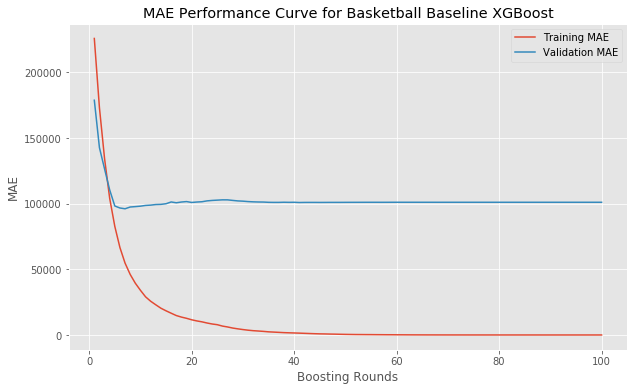

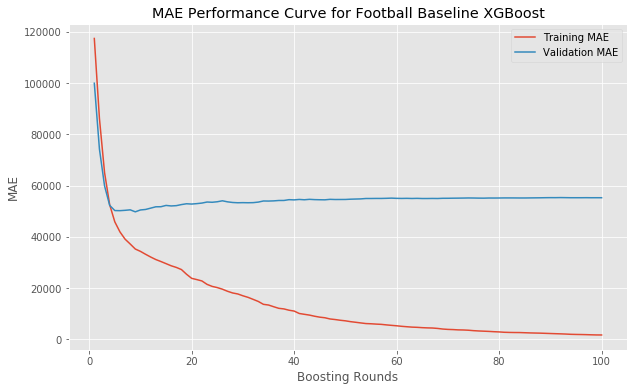

In [970]:
plot_xgb_performance('Basketball', xgb_bb, X_train_bb, y_train_bb, X_valid_bb, y_valid_bb, early_stopping_rounds=10)
plot_xgb_performance('Football',
    xgb_fb, X_train_fb, y_train_fb, X_valid_fb, y_valid_fb, early_stopping_rounds=10)

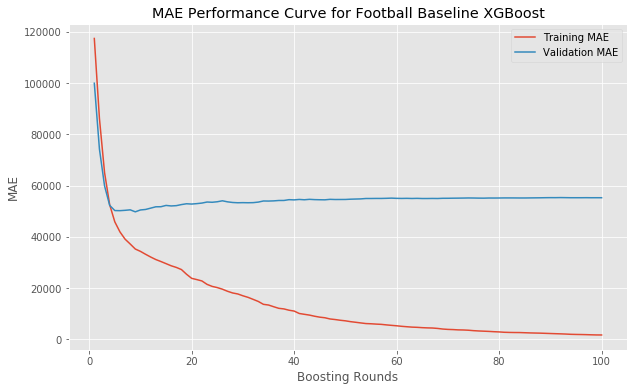

In [971]:
results = plot_xgb_performance('Football',
    xgb_fb, X_train_fb, y_train_fb, X_valid_fb, y_valid_fb, early_stopping_rounds=10)

**Feature Importance of XGB Baseline Model**

In [972]:

def plot_feature_importance(model, feature_names, name, modelname):
    # Get feature importances from the model
    feature_importances = model.feature_importances_
    
    # Create a DataFrame to store feature importances
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    
    # Sort the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

 
 # Create bar plot
    plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='orange',)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.grid(False)
    plt.title(f'XGB {modelname} Feature Importance for {name}')

    # Add importance scores at the end of the bars
    for i, v in enumerate(feature_importance_df['Importance']):
        plt.text(v, i, f' {v:.2f}', ha='left', va='center', fontsize=10, )

    plt.show()

    plt.show()

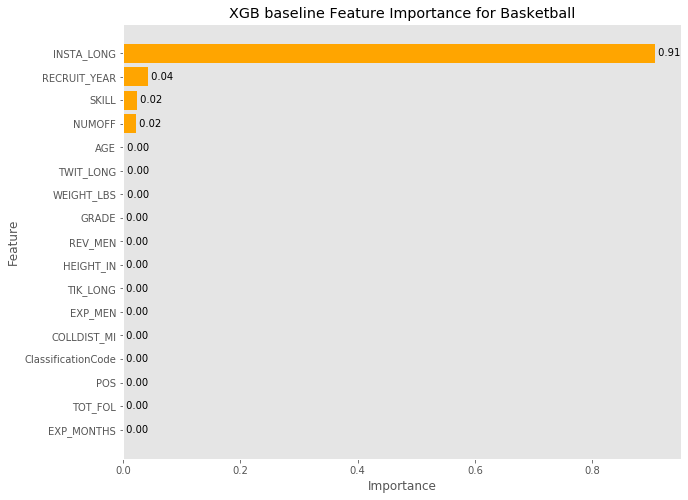

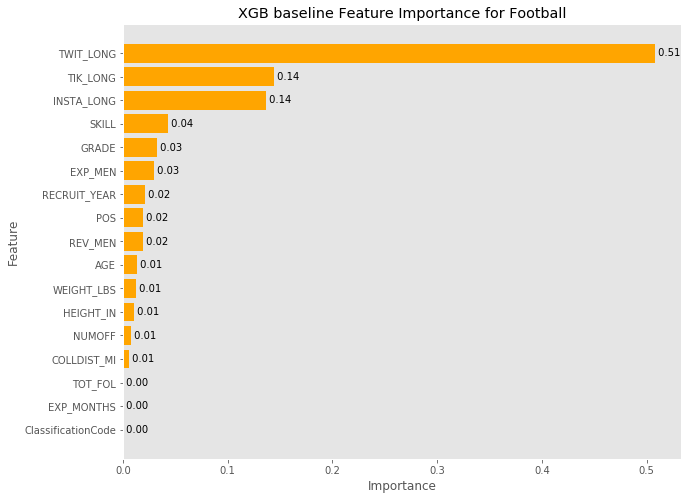

In [973]:
Target = 'NILVAL_LONG_USD'
feature_names =['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI',  'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'TOT_FOL', 'RECRUIT_YEAR', 'EXP_MONTHS', 'ClassificationCode',
       'REV_MEN', 'EXP_MEN']

plot_feature_importance(xgb_bb, feature_names, "Basketball","baseline")
plot_feature_importance(xgb_fb, feature_names, "Football", 'baseline')

**Perform Cross-Validation on XGB Baseline Model** CV is only performed on training data. 

In [987]:

# def cross_validate_xgboost_regressor(X_train, y_train, num_folds=5, random_state=42):


#     X_train = X_train.values
#     y_train = y_train.values
    
#     # Create an XGBoost regressor with default parameters
#     regressor = xgb.XGBRegressor()
    
#     # Define K-fold cross-validation
#     kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)

#     # for train_index, test_index in kf.split(X_train, y_train):
#     #     print("Train Index:", train_index)
#     #     print("Test Index:", test_index)

#     # Lists to store evaluation metrics for each fold
#     rmse_scores = []
#     mae_scores = []
#     r2_scores = []

#     # Perform cross-validation
#     for train_index, test_index in kf.split(X_train, y_train):
#         X_fold_train, X_fold_test = X_train[train_index], X_train[test_index]
#         y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]

#         regressor.fit(X_fold_train, y_fold_train)
#         y_pred = regressor.predict(X_fold_test)

#         rmse = np.sqrt(mean_squared_error(y_fold_test, y_pred))
#         mae = mean_absolute_error(y_fold_test, y_pred)
#         r2 = r2_score(y_fold_test, y_pred)

#         rmse_scores.append(rmse)
#         mae_scores.append(mae)
#         r2_scores.append(r2)

#     # Calculate and return the mean RMSE, MAE, and R2 scores
#     mean_rmse = np.mean(rmse_scores)
#     mean_mae = np.mean(mae_scores)
#     mean_r2 = np.mean(r2_scores)

#     return {
#         'mean_rmse': mean_rmse,
#         'mean_mae': mean_mae,
#         'mean_r2': mean_r2,
#         'cv_results': {
#             'rmse_scores': rmse_scores,
#             'mae_scores': mae_scores,
#             'r2_scores': r2_scores
#             }
#         }


In [1037]:
# num_folds = 10
# bb_cv=cross_validate_xgboost_regressor(X_train_bb, y_train_bb, num_folds=num_folds, random_state=42)
# # display (bb_cv)

In [993]:

def perform_kfold_cross_val(params, X_train, y_train, metrics, num_boost_round, early_stopping_rounds, num_folds=5):
    """
    Perform k-fold cross-validation for an XGBoost model.

    Parameters:
    - params: XGBoost hyperparameters
    - DM_train: DMatrix for the training data
    - metrics: List of evaluation metrics
    - num_boost_round: Number of boosting rounds
    - early_stopping_rounds: Early stopping criteria
    - num_folds: Number of cross-validation folds (default is 5)

    Returns:
    - cv_results: Cross-validation results as a pandas DataFrame
    """
    DM_train = xgb.DMatrix(data=X_train, label=y_train, enable_categorical= True)

    cv_results = xgb.cv(
        params=params,
        dtrain=DM_train,
        num_boost_round=num_boost_round,
        seed=42,  # Seed for randomization
        nfold=num_folds,
        metrics=metrics,
        early_stopping_rounds=early_stopping_rounds
    )
    return cv_results

In [1051]:
baseline_params = {
        'objective': 'reg:squarederror',
        # 'n_estimators': 1000, #boosting rounds
        'learning_rate': 0.300000012,
        'max_depth': 6,
        'subsample': 1.0,
        'colsample_bytree': 1.0,
        'random_state': 42,
        'tree_method': 'auto',
        # 'eval_metric': ['mae', 'rmse'],
        # 'early_stopping_rounds': 10
    }
num_boost_rounds = 100
metrics = ['mae', 'rmse']
early_stopping_rounds = 10
num_folds= 10

cvresults_bb = perform_kfold_cross_val(baseline_params, X_train_bb,y_train_bb, metrics, num_boost_rounds, early_stopping_rounds, num_folds=num_folds)
cvresults_fb = perform_kfold_cross_val(baseline_params, X_train_fb,y_train_fb, metrics, num_boost_rounds, early_stopping_rounds,num_folds=num_folds)

In [1052]:
def best_cv_results(name, cv_results):
    best_round = cv_results['test-rmse-mean'].idxmin()
    best_rmse = cv_results['test-rmse-mean'].min()
    best_rmse = round(best_rmse, 3)
    best_mae = cv_results['test-mae-mean'][best_round]
    best_mae = round(best_mae, 3)

    print("Best {} TEST RMSE (CV): {:.4f} at boosting round {}.".format(name, best_rmse, best_round))
    print("Best {} TEST MAE (CV): {:.4f} at boosting round {}.".format(name, best_mae, best_round))

    # Create a DataFrame with the best CV results
    best_results = pd.DataFrame({
        "Metric": [name + ' RMSE', name + ' MAE'],
        "Best Value": [best_rmse, best_mae],
        "At Boosting Round": [best_round, best_round]
    })

    return best_results

In [1053]:
best_cvresults_bb = best_cv_results('basketball',cvresults_bb)
display(best_cvresults_bb)
best_cvresults_fb = best_cv_results('football',cvresults_fb)
display(best_cvresults_fb)
display(xgb_df)

Best basketball TEST RMSE (CV): 306135.9240 at boosting round 16.
Best basketball TEST MAE (CV): 129841.9420 at boosting round 16.


,Metric,Best Value,At Boosting Round
0,basketball RMSE,306135.924,16
1,basketball MAE,129841.942,16


Best football TEST RMSE (CV): 214149.2840 at boosting round 5.
Best football TEST MAE (CV): 71189.2500 at boosting round 5.


,Metric,Best Value,At Boosting Round
0,football RMSE,214149.284,5
1,football MAE,71189.250,5


,Model,Dataset,MAE,RMSE,R2
0,XGB Regressor (Validation Set),Basketball,101067.325,254039.210,-0.430829
0,XGB Regressor (Validation Set),Football,55250.265,112424.741,0.320810


At 1000 rounds, k-fold=5: 
<br>Best basketball TEST RMSE (CV): 386454.6440 (Baseline 180416.671) at boosting round 176.
<br>Best basketball TEST MAE (CV): 132705.6990 (Baseline 110751.732) at boosting round 176.

<br>Best football TEST RMSE (CV): 233386.1540 (Baseline 83701.343) at boosting round 22.
<br>Best football TEST MAE (CV): 76491.6770 (Baseline 48708.943) at boosting round 22.
<br>CV higher than baseline - look at boosting rounds and folds


<br>At 100 rounds, k-fold=5: 
<br>Best basketball TEST RMSE (CV): 388324.8960 at boosting round 98.
<br>Best basketball TEST MAE (CV): 133014.9900 at boosting round 98.

<br>Best football TEST RMSE (CV): 233386.1540 at boosting round 22.
<br>Best football TEST MAE (CV): 76491.6770 at boosting round 22.

<br> At 100 rounds, k-fold = 10
<br>Best basketball TEST RMSE (CV): 297960.4980 at boosting round 79.
<br>Best basketball TEST MAE (CV): 130896.7120 at boosting round 79.

<br>Best football TEST RMSE (CV): 195457.1200 at boosting round 45.
<br>Best football TEST MAE (CV): 71894.3980 at boosting round 45.

At 50 rounds, k-fold=10:
<br>Best basketball TEST RMSE (CV): 301370.7200 at boosting round 49.
<br>Best basketball TEST MAE (CV): 133209.0490 at boosting round 49.

<br>Best football TEST RMSE (CV): 195457.1200 at boosting round 45.
<br>Best football TEST MAE (CV): 71894.3980 at boosting round 45.

At 45 rounds, K-fold 10. 

In [998]:
cvresults_bb.head(3)
#cvresults_fb

,train-mae-mean,train-mae-std,train-rmse-mean,train-rmse-std,test-mae-mean,test-mae-std,test-rmse-mean,test-rmse-std
0,226646.123916,22036.509676,563583.176200,153773.225606,238350.189021,107107.806141,493931.764372,451180.869694
1,173948.871238,19003.131080,471340.917612,134602.973173,201263.988857,102819.806255,465156.437561,456416.545374
2,134720.286945,16578.000501,395508.666855,117797.598059,174740.914556,101292.906762,441798.644888,452818.220863


In [1054]:
def plot_learning_curves(name, cv_results):
    num_boost_rounds = len(cv_results)

    # Plot MAE learning curve
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_boost_rounds + 1), cv_results['train-mae-mean'], label='Train MAE')
    plt.plot(range(1, num_boost_rounds + 1), cv_results['test-mae-mean'], label='Test MAE')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('MAE')
    plt.title('{} K Fold Learning Curve - MAE'.format(name))
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot RMSE learning curve
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_boost_rounds + 1), cv_results['train-rmse-mean'], label='Train RMSE')
    plt.plot(range(1, num_boost_rounds + 1), cv_results['test-rmse-mean'], label='Test RMSE')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('RMSE')
    plt.title('{} K Fold Learning Curve - RMSE'.format(name))
    plt.legend()
    plt.grid(True)
    plt.show()


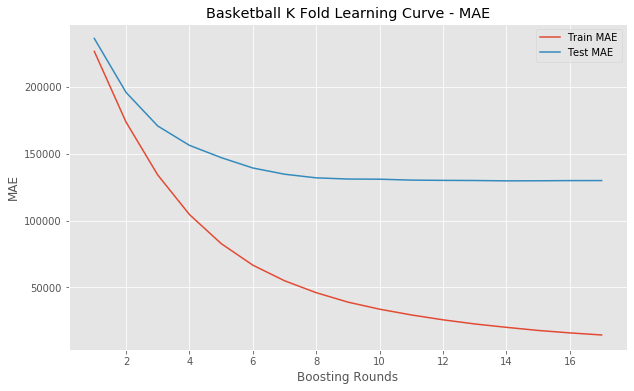

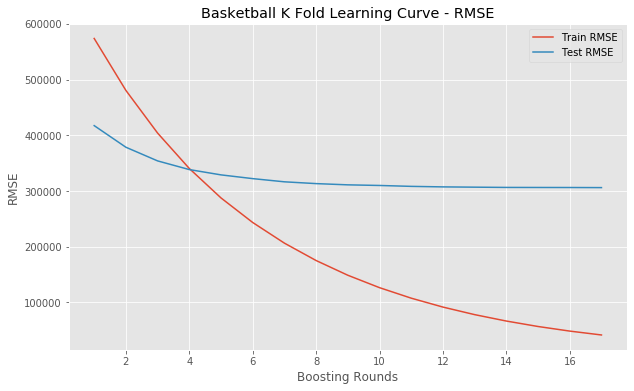

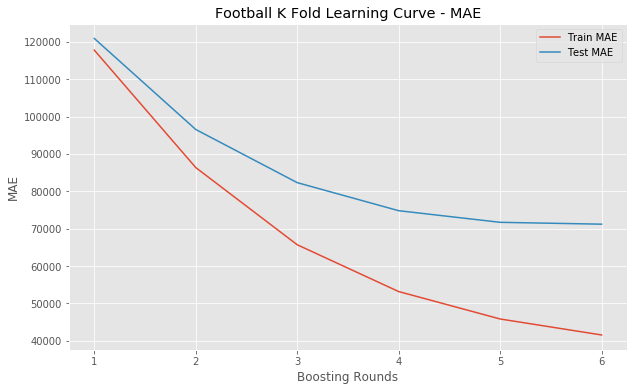

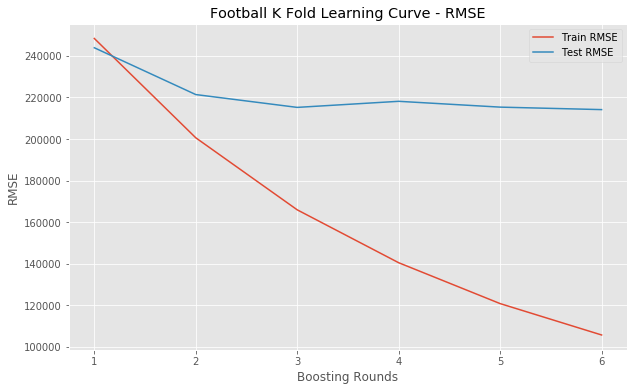

In [1055]:
plot_learning_curves ('Basketball', cvresults_bb)
plot_learning_curves ('Football', cvresults_fb)

**Perform Hyperparameter tuning and find best model**

In [1060]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error

def train_xgboost_regressor(X_train, y_train):
    # Define the parameter search space for RandomizedSearchCV
    param_dist = {
        'n_estimators': [50, 100, 150, 500, 1000],
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        # Add more hyperparameters and their respective ranges
    }

    # Initialize a K-Fold cross-validation object
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Create an XGBoost regressor
    xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist')

    # Perform RandomizedSearchCV to find the best hyperparameters
    random_search = RandomizedSearchCV(estimator=xgb_regressor, param_distributions=param_dist, n_iter=10, scoring='neg_mean_squared_error', cv=kf)
    random_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = random_search.best_params_

    # Train the final model with the best hyperparameters
    best_xgb_model = xgb.XGBRegressor(**best_params)
    best_xgb_model.fit(X_train, y_train)

    # Optional: Perform cross-validation on the final model for further evaluation
    mse_scores = cross_val_score(best_xgb_model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
    mse_scores = -mse_scores  # Convert scores to positive values

    # Calculate the average MSE and standard deviation
    avg_mse = mse_scores.mean()
    std_mse = mse_scores.std()

    return best_xgb_model, best_params, avg_mse, std_mse




In [ ]:
# Usage:
# best_model, best_hyperparameters, avg_mse, std_mse = train_xgboost_regressor(X_train, y_train

In [ ]:
#Define parameter gird
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    # 'min_child_weight': [1, 2, 3, 4, 5],
    # 'eta': [0.01, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    # 'gamma': [0, 0.1, 0.2, 0.3],
    # 'reg_alpha': [0, 0.1, 0.2, 0.3],
    # 'reg_lambda': [0.1, 1, 10, 100],
     'eval_metric': ['rmse', 'mae'],
    # Other parameters-fixed
    'objective': ['reg:squarederror'],
    'tree_method': ['hist'],
    # 'verbosity': 1
}



# def hyperparameter_tune_and_eval(X_train, y_train, X_test, y_test, param_grid):
#     # Perform hyperparameter tuning using GridSearchCV
#     model = xgb.XGBRegressor()  
#     grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')  # Use appropriate scoring
#     grid_search.fit(X_train, y_train)
#     best_model = grid_search.best_estimator_
    
#     # Fit the best model to the entire training dataset
#     best_model.fit(X_train, y_train)
    
#     # Evaluate the best model on the test dataset
#     y_pred = best_model.predict(X_test)
    
#     # Calculate performance metrics (e.g., mean squared error, mean absolute error)
#     mse = mean_squared_error(y_test, y_pred)
#     mae = mean_absolute_error(y_test, y_pred)
#     rmse = np.sqrt(mse)
#     r2 = r2_score(y_test, y_pred)
    
#     return best_model, grid_search.best_params_, rmse, mae, r2


In [1056]:
def perform_random_search(X_train, y_train, X_test, y_test, param_dist, n_iter=50, cv=5, random_state=42):
    # Define your XGBoost model
    model = xgb.XGBRegressor()
    
    # Create a RandomizedSearchCV object
    random_search = RandomizedSearchCV(
        model, param_distributions=param_dist, n_iter=n_iter, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, random_state=random_state
    )

    # Fit the random search object to your data
    random_search.fit(X_train, y_train)

    # Get the best model and best hyperparameters
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_

    # Evaluate the best model on the test set
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    return best_model, best_params, mse, mae, rmse


In [1059]:


param_grid = {
    'n_estimators': [50, 100, 150, 500, 1000],  # Smaller values like 50-150
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
 
    'colsample_bytree': [0.8, 0.9, 1.0],

     'eval_metric': ['rmse', 'mae'],
    'objective': ['reg:squarederror'],
    'tree_method': ['hist']
}

# best_model_bb, best_params_bb, mse_bb, mae_bb, rmse_bb = perform_random_search(X_train_bb, y_train_bb, X_test_bb, y_test_bb, param_grid)

best_model_bb, best_params_bb, mse_bb, mae_bb, rmse_bb = perform_random_search(X_train_bb, y_train_bb, X_valid_bb, y_valid_bb, param_grid)

print("Best Basketball Hyperparameters:", best_params_bb)
# print("Mean Squared Error on Test Set:", mse_bb)
print("Mean Absolute Error on Test Set:", mae_bb)
print("Root Mean Squared Error on Test Set:", rmse_bb)

Best Basketball Hyperparameters: {'tree_method': 'hist', 'subsample': 0.9, 'objective': 'reg:squarederror', 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.3, 'eval_metric': 'rmse', 'colsample_bytree': 0.8}
Mean Absolute Error on Test Set: 118940.43954613095
Root Mean Squared Error on Test Set: 252110.30664055495


In [1057]:


param_grid = {
    'n_estimators': [50, 100, 150, 500, 1000],  # Smaller values like 50-150
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
 
    'colsample_bytree': [0.8, 0.9, 1.0],

     'eval_metric': ['rmse', 'mae'],
    'objective': ['reg:squarederror'],
    'tree_method': ['hist']
}

best_model_fb, best_params, mse, mae, rmse = perform_random_search(X_train_fb, y_train_fb, X_test_fb, y_test_fb, param_grid)
print("Best Football Hyperparameters:", best_params)
# print("Mean Squared Error on Test Set:", mse)
print("Mean Absolute Error on Test Set:", mae)
print("Root Mean Squared Error on Test Set:", rmse)

Best Football Hyperparameters: {'tree_method': 'hist', 'subsample': 0.8, 'objective': 'reg:squarederror', 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.3, 'eval_metric': 'mae', 'colsample_bytree': 0.9}
Mean Absolute Error on Test Set: 65229.517945620886
Root Mean Squared Error on Test Set: 122057.45411434842


In [1058]:
display(xgb_base_df)

,Model,Dataset,MAE,RMSE,R2
0,XGB Regressor (Validation Set),Basketball,101067.325,254039.210,-0.430829
0,XGB Regressor (Validation Set),Football,55250.265,112424.741,0.320810
